In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_simple as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf


# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100
global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [15]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5503316060072039 	 Validation loss: 0.38803738759735884 	 
  1%|          | 574/57400 [01:41<2:30:39,  6.29it/s]
Epoch 2 	 Training loss: 0.3743748164602688 	 Validation loss: 0.34670397083638077 	 
  2%|▏         | 1148/57400 [03:21<2:39:31,  5.88it/s]
Epoch 3 	 Training loss: 0.3392011959378312 	 Validation loss: 0.33052941449617934 	 
  3%|▎         | 1722/57400 [05:01<2:36:24,  5.93it/s]
Epoch 4 	 Training loss: 0.3209480156518441 	 Validation loss: 0.3209601001719297 	 
  4%|▍         | 2296/57400 [06:42<2:37:18,  5.84it/s]
Epoch 5 	 Training loss: 0.3065521145427684 	 Validation loss: 0.3166608365915589 	 
  5%|▌         | 2870/57400 [08:22<2:30:10,  6.05it/s]
Epoch 6 	 Training loss: 0.2927967464934243 	 Validation loss: 0.308116661542553 	 
  6%|▌         | 3444/57400 [10:02<2:46:29,  5.40it/s]
Epoch 7 	 Training loss: 0.2821801067021666 	 Validation loss: 0.3063885998927941 	 
  7%|▋         | 4018/57400 [11:43<2:24:19,  6.16it/s]
Epoch 8 	 Training 

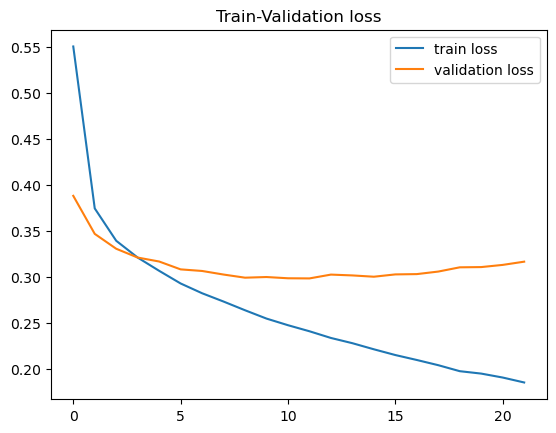

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [42]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('simple_bert_about'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8405612244897959, 'precision': 0.8405612244897959, 'f1': 0.8405612244897959, 'accuracy': 0.8405612244897959}
MALE {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}
FEMALE {'recall': 0.8475, 'precision': 0.8475, 'f1': 0.8475, 'accuracy': 0.8475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6868686868686869, 'precision': 0.6868686868686869, 'f1': 0.6868686868686869, 'accuracy': 0.6868686868686869}
MALE {'recall': 0.681265206812652, 'precision': 0.681265206812652, 'f1': 0.681265206812652, 'accuracy': 0.681265206812652}
FEMALE {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
MALE {'recall': 0.67

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5787523758016813 	 Validation loss: 0.4113915825294236 	 
  1%|          | 574/57400 [01:36<2:41:12,  5.88it/s]
Epoch 2 	 Training loss: 0.38373975876316374 	 Validation loss: 0.348273002747762 	 
  2%|▏         | 1148/57400 [03:10<2:33:05,  6.12it/s]
Epoch 3 	 Training loss: 0.3441897904312154 	 Validation loss: 0.332978116253675 	 
  3%|▎         | 1722/57400 [04:45<2:41:30,  5.75it/s]
Epoch 4 	 Training loss: 0.3229457379322019 	 Validation loss: 0.3251316512035111 	 
  4%|▍         | 2296/57400 [06:21<2:38:46,  5.78it/s]
Epoch 5 	 Training loss: 0.30987948760753725 	 Validation loss: 0.31471878593250857 	 
  5%|▌         | 2870/57400 [07:57<2:19:57,  6.49it/s]
Epoch 6 	 Training loss: 0.2961085826833489 	 Validation loss: 0.30958705332319614 	 
  6%|▌         | 3444/57400 [09:32<2:15:02,  6.66it/s]
Epoch 7 	 Training loss: 0.28420603306451325 	 Validation loss: 0.3058695868920472 	 
  7%|▋         | 4018/57400 [11:08<2:20:42,  6.32it/s]
Epoch 8 	 Training

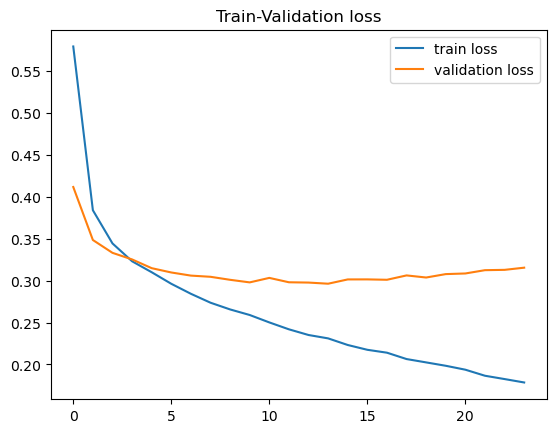

In [18]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [44]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('simple_bert_about2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979592, 'accuracy': 0.8431122448979592}
MALE {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}
FEMALE {'recall': 0.8525, 'precision': 0.8525, 'f1': 0.8525, 'accuracy': 0.8525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6881313131313131, 'precision': 0.6881313131313131, 'f1': 0.6881313131313131, 'accuracy': 0.6881313131313131}
MALE {'recall': 0.6739659367396593, 'precision': 0.6739659367396593, 'f1': 0.6739659367396593, 'accuracy': 0.6739659367396593}
FEMALE {'recall': 0.7034120734908137, 'precision': 0.7034120734908137, 'f1': 0.7034120734908137, 'accuracy': 0.7034120734908137} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6805736636245111, 'precision': 0.6805736636245111, 'f1': 0.6805736636245111, 'accuracy': 0.6805736636245111}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.558136565811958 	 Validation loss: 0.3959960326299829 	 
  1%|          | 574/57400 [01:39<2:45:31,  5.72it/s]
Epoch 2 	 Training loss: 0.3777815765256666 	 Validation loss: 0.3483834397994866 	 
  2%|▏         | 1148/57400 [03:20<2:30:45,  6.22it/s]
Epoch 3 	 Training loss: 0.33965212734941824 	 Validation loss: 0.3333747217715797 	 
  3%|▎         | 1722/57400 [04:59<2:26:32,  6.33it/s]
Epoch 4 	 Training loss: 0.32232439216836406 	 Validation loss: 0.32346222739098435 	 
  4%|▍         | 2296/57400 [06:37<2:49:34,  5.42it/s]
Epoch 5 	 Training loss: 0.306744353540683 	 Validation loss: 0.3152345992245917 	 
  5%|▌         | 2870/57400 [08:16<2:22:14,  6.39it/s]
Epoch 6 	 Training loss: 0.29419306528069833 	 Validation loss: 0.3089593482219567 	 
  6%|▌         | 3444/57400 [09:56<2:29:21,  6.02it/s]
Epoch 7 	 Training loss: 0.28391461406642965 	 Validation loss: 0.3070299794613305 	 
  7%|▋         | 4018/57400 [11:35<2:36:50,  5.67it/s]
Epoch 8 	 Training

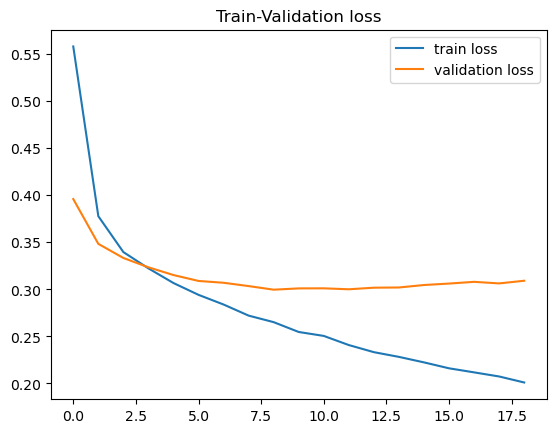

In [45]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [48]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979592, 'accuracy': 0.8431122448979592}
MALE {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}
FEMALE {'recall': 0.8375, 'precision': 0.8375, 'f1': 0.8375, 'accuracy': 0.8375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6856060606060606, 'precision': 0.6856060606060606, 'f1': 0.6856060606060606, 'accuracy': 0.6856060606060606}
MALE {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}
FEMALE {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.681877444589309, 'precision': 0.681877444589309, 'f1': 0.681877444589309, 'accuracy': 0.681877444589309}
MALE {'recall': 0.686868

Resultados finales

In [50]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8420918367346939, 'precision': 0.8420918367346939, 'f1': 0.8420918367346939, 'accuracy': 0.8420918367346939}
Métricas etiqueta male: {'recall': 0.8395833333333333, 'precision': 0.8395833333333333, 'f1': 0.8395833333333333, 'accuracy': 0.8395833333333333}
Métricas etiqueta female:  {'recall': 0.8445, 'precision': 0.8445, 'f1': 0.8445, 'accuracy': 0.8445}

 to
Resultado global: {'recall': 0.6866161616161616, 'precision': 0.6866161616161616, 'f1': 0.6866161616161616, 'accuracy': 0.6866161616161616}
Métricas etiqueta male: {'recall': 0.6807785888077859, 'precision': 0.6807785888077859, 'f1': 0.6807785888077859, 'accuracy': 0.6807785888077859}
Métricas etiqueta female:  {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716}

 as
Resultado global: {'recall': 0.6821382007822686, 'precision': 0.6821382007822686, 'f1': 0.6821382007822686, 'accuracy': 0.6821382007822686}

# TO

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6983321208364042 	 Validation loss: 0.6939202021744292 	 
  1%|          | 574/57400 [01:36<2:23:46,  6.59it/s]
Epoch 2 	 Training loss: 0.6959571140568431 	 Validation loss: 0.6943353899454666 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:12<2:23:47,  6.52it/s]
Epoch 3 	 Training loss: 0.6949054729647752 	 Validation loss: 0.6928944506887662 	 
  3%|▎         | 1722/57400 [04:51<2:30:34,  6.16it/s]
Epoch 4 	 Training loss: 0.6947814507559201 	 Validation loss: 0.6943350899017463 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:30<2:31:58,  6.04it/s]
Epoch 5 	 Training loss: 0.6946173972784434 	 Validation loss: 0.6930112515465688 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:09<2:19:26,  6.52it/s]
Epoch 6 	 Training loss: 0.6943857470455901 	 Validation loss: 0.6920362882694956 	 
  6%|▌         | 3444/57400 [09:48<2:40:38,  5.60it/s]
Epoch 7 	 Training loss: 0.694391065254444 	 Validation loss: 0.6952186337

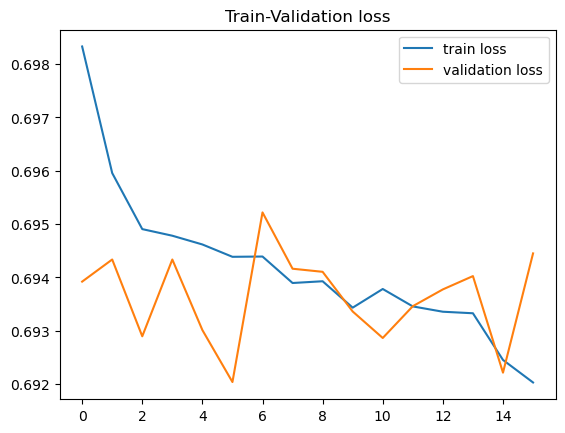

In [23]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [16]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('simple_bert_to'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5318877551020408, 'precision': 0.5318877551020408, 'f1': 0.5318877551020408, 'accuracy': 0.5318877551020408}
MALE {'recall': 0.08854166666666667, 'precision': 0.08854166666666667, 'f1': 0.08854166666666667, 'accuracy': 0.08854166666666667}
FEMALE {'recall': 0.9575, 'precision': 0.9575, 'f1': 0.9575, 'accuracy': 0.9575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5037878787878788, 'precision': 0.5037878787878788, 'f1': 0.5037878787878788, 'accuracy': 0.5037878787878788}
MALE {'recall': 0.11192214111922141, 'precision': 0.11192214111922141, 'f1': 0.11192214111922141, 'accuracy': 0.11192214111922141}
FEMALE {'recall': 0.926509186351706, 'precision': 0.926509186351706, 'f1': 0.926509186351706, 'accuracy': 0.926509186351706} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5097783572359843, 'precision': 0.5097783572359843, 'f1': 0.5097783572359843, 'accuracy': 0.5097783572359843}
MALE {'recal

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.698203797228245 	 Validation loss: 0.693197526163974 	 
  1%|          | 574/57400 [01:37<2:36:06,  6.07it/s]
Epoch 2 	 Training loss: 0.6953941721741747 	 Validation loss: 0.6936459076606621 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:12<2:45:55,  5.65it/s]
Epoch 3 	 Training loss: 0.694603717700945 	 Validation loss: 0.6922875481136774 	 
  3%|▎         | 1722/57400 [04:49<2:26:41,  6.33it/s]
Epoch 4 	 Training loss: 0.6944323937028958 	 Validation loss: 0.6927115381774256 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:24<2:55:54,  5.22it/s]
Epoch 5 	 Training loss: 0.6944094010554124 	 Validation loss: 0.6945134896343037 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:00<2:18:22,  6.57it/s]
Epoch 6 	 Training loss: 0.6939107645887116 	 Validation loss: 0.692946134987524 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:38<2:17:44,  6.53it/s]
Epoch 7 	 Training loss: 0.6935329195306692 	 Val

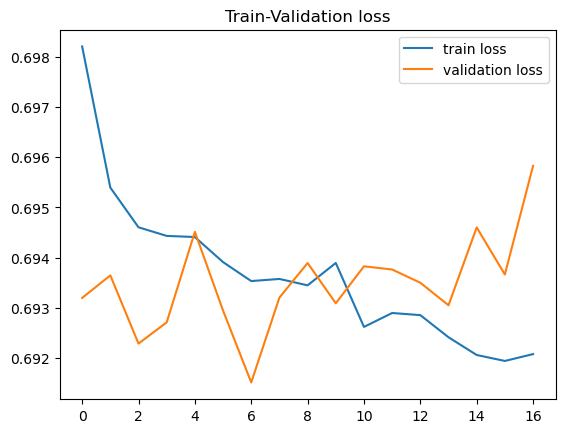

In [25]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('simple_bert_to2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5510204081632653, 'precision': 0.5510204081632653, 'f1': 0.5510204081632653, 'accuracy': 0.5510204081632653}
MALE {'recall': 0.22395833333333334, 'precision': 0.22395833333333334, 'f1': 0.22395833333333334, 'accuracy': 0.22395833333333334}
FEMALE {'recall': 0.865, 'precision': 0.865, 'f1': 0.865, 'accuracy': 0.865} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5378787878787878, 'precision': 0.5378787878787878, 'f1': 0.5378787878787878, 'accuracy': 0.5378787878787878}
MALE {'recall': 0.20924574209245742, 'precision': 0.20924574209245742, 'f1': 0.20924574209245742, 'accuracy': 0.20924574209245742}
FEMALE {'recall': 0.8923884514435696, 'precision': 0.8923884514435696, 'f1': 0.8923884514435696, 'accuracy': 0.8923884514435696} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5371577574967406, 'precision': 0.5371577574967406, 'f1': 0.5371577574967406, 'accuracy': 0.5371577574967406}
MALE {'recal

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6987189799027991 	 Validation loss: 0.6924913424556538 	 
  1%|          | 574/57400 [01:37<2:25:51,  6.49it/s]
Epoch 2 	 Training loss: 0.6952650348691575 	 Validation loss: 0.6925807696277813 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:13<2:36:16,  6.00it/s]
Epoch 3 	 Training loss: 0.6948069727586952 	 Validation loss: 0.6923785037913565 	 
  3%|▎         | 1722/57400 [04:50<2:43:25,  5.68it/s]
Epoch 4 	 Training loss: 0.6944586922275064 	 Validation loss: 0.6926043336674318 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:25<2:28:59,  6.16it/s]
Epoch 5 	 Training loss: 0.6944446220007507 	 Validation loss: 0.6920902446164923 	 
  5%|▌         | 2870/57400 [08:03<2:22:34,  6.37it/s]
Epoch 6 	 Training loss: 0.6941648069574442 	 Validation loss: 0.6921051073882539 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:41<2:17:23,  6.55it/s]
Epoch 7 	 Training loss: 0.6939573173738938 	 Validation loss: 0.693484790

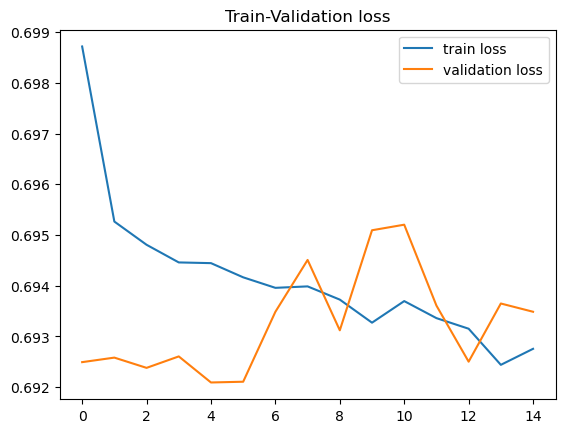

In [27]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load('simple_bert_to3'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5191326530612245, 'precision': 0.5191326530612245, 'f1': 0.5191326530612245, 'accuracy': 0.5191326530612245}
MALE {'recall': 0.4479166666666667, 'precision': 0.4479166666666667, 'f1': 0.4479166666666667, 'accuracy': 0.4479166666666667}
FEMALE {'recall': 0.5875, 'precision': 0.5875, 'f1': 0.5875, 'accuracy': 0.5875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5366161616161617, 'precision': 0.5366161616161617, 'f1': 0.5366161616161617, 'accuracy': 0.5366161616161617}
MALE {'recall': 0.6423357664233577, 'precision': 0.6423357664233577, 'f1': 0.6423357664233577, 'accuracy': 0.6423357664233577}
FEMALE {'recall': 0.4225721784776903, 'precision': 0.4225721784776903, 'f1': 0.4225721784776903, 'accuracy': 0.4225721784776903} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5267275097783573, 'precision': 0.5267275097783573, 'f1': 0.5267275097783573, 'accuracy': 0.5267275097783573}
MALE {'recall': 

Resultados finales

In [19]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5340136054421768, 'precision': 0.5340136054421768, 'f1': 0.5340136054421768, 'accuracy': 0.5340136054421768}
Métricas etiqueta male: {'recall': 0.2534722222222222, 'precision': 0.2534722222222222, 'f1': 0.2534722222222222, 'accuracy': 0.2534722222222222}
Métricas etiqueta female:  {'recall': 0.8033333333333333, 'precision': 0.8033333333333333, 'f1': 0.8033333333333333, 'accuracy': 0.8033333333333333}

 to
Resultado global: {'recall': 0.5260942760942761, 'precision': 0.5260942760942761, 'f1': 0.5260942760942761, 'accuracy': 0.5260942760942761}
Métricas etiqueta male: {'recall': 0.32116788321167883, 'precision': 0.32116788321167883, 'f1': 0.32116788321167883, 'accuracy': 0.32116788321167883}
Métricas etiqueta female:  {'recall': 0.7471566054243219, 'precision': 0.7471566054243219, 'f1': 0.7471566054243219, 'accuracy': 0.7471566054243219}

 as
Resultado global: {'recall': 0.5245545415036941, 'precision': 0.5245545415036941, 'f1':

# AS

In [30]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955885604698899 	 Validation loss: 0.6933662689338296 	 
  1%|          | 574/57400 [01:37<2:16:04,  6.96it/s]
Epoch 2 	 Training loss: 0.693994162390041 	 Validation loss: 0.6927261605101117 	 
  2%|▏         | 1148/57400 [03:15<2:21:44,  6.61it/s]
Epoch 3 	 Training loss: 0.6924011048954953 	 Validation loss: 0.6929030782085354 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:52<2:41:32,  5.74it/s]
Epoch 4 	 Training loss: 0.6915108512710612 	 Validation loss: 0.6921481762902212 	 
  4%|▍         | 2296/57400 [06:31<2:19:37,  6.58it/s]
Epoch 5 	 Training loss: 0.6891526730426097 	 Validation loss: 0.692766276456542 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:10<2:34:07,  5.90it/s]
Epoch 6 	 Training loss: 0.6882442970101427 	 Validation loss: 0.6881554742990914 	 
  6%|▌         | 3444/57400 [09:48<2:38:57,  5.66it/s]
Epoch 7 	 Training loss: 0.6859344450646576 	 Validation loss: 0.6881931242296251 	 

1 epoch without imp

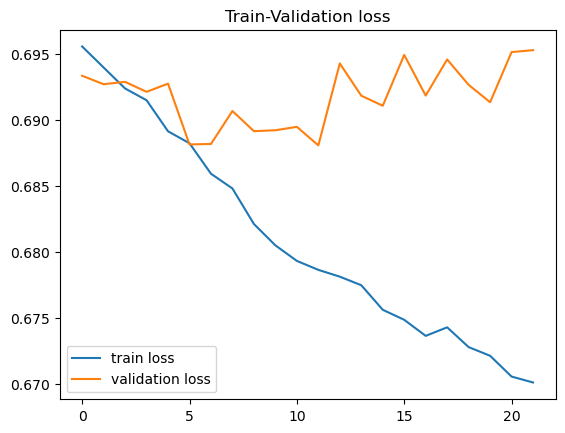

In [31]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6670918367346939, 'precision': 0.6670918367346939, 'f1': 0.6670918367346939, 'accuracy': 0.6670918367346939}
MALE {'recall': 0.6171875, 'precision': 0.6171875, 'f1': 0.6171875, 'accuracy': 0.6171875}
FEMALE {'recall': 0.715, 'precision': 0.715, 'f1': 0.715, 'accuracy': 0.715} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6868686868686869, 'precision': 0.6868686868686869, 'f1': 0.6868686868686869, 'accuracy': 0.6868686868686869}
MALE {'recall': 0.6982968369829684, 'precision': 0.6982968369829684, 'f1': 0.6982968369829684, 'accuracy': 0.6982968369829684}
FEMALE {'recall': 0.6745406824146981, 'precision': 0.6745406824146981, 'f1': 0.6745406824146981, 'accuracy': 0.6745406824146981} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7979139504563233, 'precision': 0.7979139504563233, 'f1': 0.7979139504563233, 'accuracy': 0.7979139504563233}
MALE {'recall': 0.75, 'precision': 0.75, 'f1': 0.75, 'ac

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6979100109185076 	 Validation loss: 0.6926951570025945 	 
  1%|          | 574/57400 [01:36<2:46:37,  5.68it/s]
Epoch 2 	 Training loss: 0.6938399326718228 	 Validation loss: 0.6934282688771264 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:12<2:27:30,  6.36it/s]
Epoch 3 	 Training loss: 0.693207152525307 	 Validation loss: 0.6923235877085541 	 
  3%|▎         | 1722/57400 [04:48<2:27:30,  6.29it/s]
Epoch 4 	 Training loss: 0.691882277614979 	 Validation loss: 0.692188416497182 	 
  4%|▍         | 2296/57400 [06:25<2:26:36,  6.26it/s]
Epoch 5 	 Training loss: 0.6909081882923738 	 Validation loss: 0.690850178063926 	 
  5%|▌         | 2870/57400 [08:01<2:36:44,  5.80it/s]
Epoch 6 	 Training loss: 0.689221555347642 	 Validation loss: 0.6906490921974182 	 
  6%|▌         | 3444/57400 [09:37<2:22:31,  6.31it/s]
Epoch 7 	 Training loss: 0.6884570130072404 	 Validation loss: 0.6919715364100569 	 

1 epoch without improvement
  7%|▋         | 4018/5

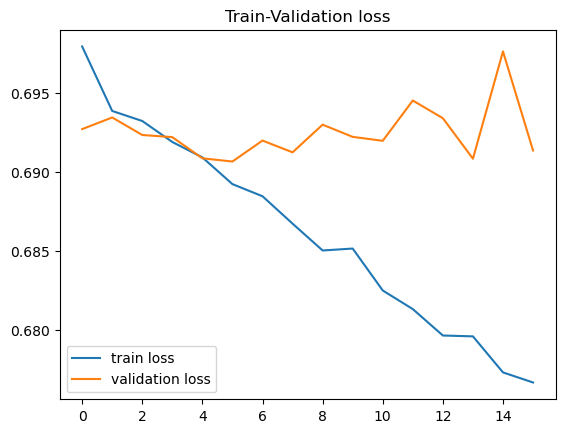

In [33]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5727040816326531, 'precision': 0.5727040816326531, 'f1': 0.5727040816326531, 'accuracy': 0.5727040816326531}
MALE {'recall': 0.3515625, 'precision': 0.3515625, 'f1': 0.3515625, 'accuracy': 0.3515625}
FEMALE {'recall': 0.785, 'precision': 0.785, 'f1': 0.785, 'accuracy': 0.785} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5909090909090909, 'precision': 0.5909090909090909, 'f1': 0.5909090909090909, 'accuracy': 0.5909090909090909}
MALE {'recall': 0.45985401459854014, 'precision': 0.45985401459854014, 'f1': 0.45985401459854014, 'accuracy': 0.45985401459854014}
FEMALE {'recall': 0.7322834645669292, 'precision': 0.7322834645669292, 'f1': 0.732283464566929, 'accuracy': 0.7322834645669292} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6101694915254238, 'precision': 0.6101694915254238, 'f1': 0.6101694915254238, 'accuracy': 0.6101694915254238}
MALE {'recall': 0.40404040404040403, 'precision': 0.4

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695093621567982 	 Validation loss: 0.6918938281172413 	 
  1%|          | 574/57400 [01:35<2:28:50,  6.36it/s]
Epoch 2 	 Training loss: 0.6942926130228342 	 Validation loss: 0.6936331462051909 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:11<2:43:03,  5.75it/s]
Epoch 3 	 Training loss: 0.6935544444916556 	 Validation loss: 0.6917063159457708 	 
  3%|▎         | 1722/57400 [04:47<2:27:03,  6.31it/s]
Epoch 4 	 Training loss: 0.6925157720826645 	 Validation loss: 0.6912917504876347 	 
  4%|▍         | 2296/57400 [06:23<2:35:49,  5.89it/s]
Epoch 5 	 Training loss: 0.6908906753262576 	 Validation loss: 0.6928690671920776 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:59<2:19:53,  6.50it/s]
Epoch 6 	 Training loss: 0.6896054100907223 	 Validation loss: 0.6901151628817542 	 
  6%|▌         | 3444/57400 [09:36<2:15:41,  6.63it/s]
Epoch 7 	 Training loss: 0.6883619444295505 	 Validation loss: 0.6907544469429274 	 

1 epoch without im

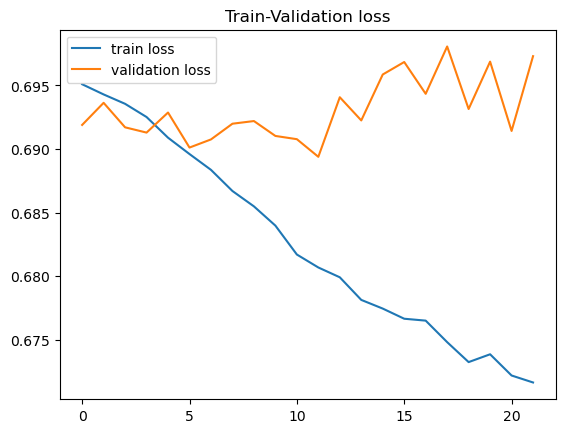

In [35]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_bert_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6862244897959183, 'precision': 0.6862244897959183, 'f1': 0.6862244897959183, 'accuracy': 0.6862244897959183}
MALE {'recall': 0.6510416666666666, 'precision': 0.6510416666666666, 'f1': 0.6510416666666666, 'accuracy': 0.6510416666666666}
FEMALE {'recall': 0.72, 'precision': 0.72, 'f1': 0.72, 'accuracy': 0.72} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6944444444444444, 'precision': 0.6944444444444444, 'f1': 0.6944444444444444, 'accuracy': 0.6944444444444444}
MALE {'recall': 0.7153284671532847, 'precision': 0.7153284671532847, 'f1': 0.7153284671532847, 'accuracy': 0.7153284671532847}
FEMALE {'recall': 0.6719160104986877, 'precision': 0.6719160104986877, 'f1': 0.6719160104986877, 'accuracy': 0.6719160104986877} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7640156453715776, 'precision': 0.7640156453715776, 'f1': 0.7640156453715776, 'accuracy': 0.7640156453715776}
MALE {'recall': 0.727272

Resultados finales

In [40]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6420068027210885, 'precision': 0.6420068027210885, 'f1': 0.6420068027210885, 'accuracy': 0.6420068027210885}
Métricas etiqueta male: {'recall': 0.5399305555555556, 'precision': 0.5399305555555556, 'f1': 0.5399305555555556, 'accuracy': 0.5399305555555556}
Métricas etiqueta female:  {'recall': 0.74, 'precision': 0.74, 'f1': 0.74, 'accuracy': 0.74}

 to
Resultado global: {'recall': 0.6574074074074074, 'precision': 0.6574074074074074, 'f1': 0.6574074074074074, 'accuracy': 0.6574074074074074}
Métricas etiqueta male: {'recall': 0.624493106244931, 'precision': 0.624493106244931, 'f1': 0.624493106244931, 'accuracy': 0.624493106244931}
Métricas etiqueta female:  {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716}

 as
Resultado global: {'recall': 0.7240330291177749, 'precision': 0.7240330291177749, 'f1': 0.7240330291177749, 'accuracy': 0.7240330291177749}
Métricas et